# Climate Modeling Final Project
###  Reproducing the global cloud cover decrease from MPI-ESM-LR global mean surface temperatures using a cloud albedo-cloud fraction parameterization
Alberto Patania and Nina Robbins Blanch
(Universitat Hamburg)

#### Goal
- To test if we are able to reproduce the global cloud fraction decrease using a power law cloud albedo-cloud fraction relationship parameterization in the 0-D energy balance model with a single cloud layer. The parameterization comes from Engstrom et al. 2015 (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015GL066275) and Feingold et al. 2017 (http://doi.wiley.com/10.1002/2017JD026467):

$$ \alpha_c = \gamma c^{\delta} $$


#### Procedure
- Take global average surface temperature from the MPI-ESM-LR (which contains all the detailed information from an ESM), compute the cloud temperature assuming a constant moist adiabatic lapse rate. Using the energy balance at the surface, solve for $\alpha_c$ that gives equilibrium, then solve for $c$ using a power law parameterization, and tune $\gamma$ and $\delta$ so that we get the minimum difference between the ESM global mean cloud fraction and the cloud fraction computed with the 0-D EBM.

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime as dt

import pandas as pd
import glob
from sympy import Symbol
from sympy.solvers import solve
import time

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

%matplotlib inline

### 1. Get output from MPI-ESM-LR
Select only from -60 to 60, to avoid ice effect on albedo when averaging the temperature and cloud fractions

In [120]:
########################################
# temperature
########################################

# Historical
ts_list = glob.glob('/home/ninarobbins/UHH/Climate-Modeling-S22/cm_data/cmip6/ts_hist_files/*')
hist_temp = xr.open_mfdataset(ts_list).groupby('time.year').mean('time')
hist_temp = hist_temp.rename({'ts':'T_surf'}).sel(lat=slice(-60,60))

# SSP5-8.5
ts_list = glob.glob('/home/ninarobbins/UHH/Climate-Modeling-S22/cm_data/cmip6/ts_ss85_files/*')
ss585_temp =  xr.open_mfdataset(ts_list).groupby('time.year').mean('time')
ss585_temp = ss585_temp.rename({'ts':'T_surf'}).sel(lat=slice(-60,60))

########################################
# cloud cover from MPI-ESM-LR
# Fraction of horizontal area occupied by clouds as seen from the surface to the top of the atmosphere in the whole atmosphere column.
########################################

# Historical
total_cloud_list_hist = glob.glob('/home/ninarobbins/UHH/Climate-Modeling-S22/cm_data/cmip6/cloud_hist_files/*')
total_cloud_data_hist = xr.open_mfdataset(total_cloud_list_hist).groupby('time.year').mean('time').sel(lat=slice(-60,60)) #.resample(time="M").mean()
cc_hist = total_cloud_data_hist.clt/100

# SSP5-8.5
total_cloud_list_ss585 = glob.glob('/home/ninarobbins/UHH/Climate-Modeling-S22/cm_data/cmip6/cc_ss85_files/*')
total_cloud_data_ss585 = xr.open_mfdataset(total_cloud_list_ss585).groupby('time.year').mean('time').sel(lat=slice(-60,60)) #.resample(time="M").mean()
cc_ss85 = total_cloud_data_ss585.clt/100

### 2. Compute global average surface temperature and cloud cover

In [121]:
# Generate weights for the sum
weights = np.cos(np.deg2rad(cc_hist.lat))
weights.name = "weights"

#Cloud cover
cc_weighted_hist = cc_hist.weighted(weights)
cc_mean_hist = cc_weighted_hist.mean(("lon", "lat"))

cc_weighted_ss85 = cc_ss85.weighted(weights)
cc_mean_ss85 = cc_weighted_ss85.mean(("lon", "lat"))

# Surface temperature
temp_weighted_hist = hist_temp.T_surf.weighted(weights)
temp_mean_hist = temp_weighted_hist.mean(("lon", "lat"))

temp_weighted_ss85 = ss585_temp.T_surf.weighted(weights)
temp_mean_ss85 = temp_weighted_ss85.mean(("lon", "lat"))

# Add variables to a dataset

data_hist = xr.Dataset()
data_hist = data_hist.assign(Ts = temp_mean_hist)
data_hist = data_hist.assign(cc = cc_mean_hist)

data_ssp85 = xr.Dataset()
data_ssp85 = data_ssp85.assign(Ts = temp_mean_ss85)
data_ssp85 = data_ssp85.assign(cc = cc_mean_ss85)

### 3. Get cloud temperature from moist adiabatic lapse rate

In [122]:
# Choose altitude in km
z_low = 1.5
z_mid = 5
z_high = 10
z = [z_low, z_mid, z_high]

# Add a cloud layer assuming moist adiabatic lapse rate
gamma = -6.5 # K/km

# cloud temp
data_hist = data_hist.assign(Tc_low = data_hist.Ts + gamma*z_low)
data_hist = data_hist.assign(Tc_mid = data_hist.Ts + gamma*z_mid)
data_hist = data_hist.assign(Tc_high = data_hist.Ts + gamma*z_high)

data_ssp85 = data_ssp85.assign(Tc_low = data_ssp85.Ts + gamma*z_low)
data_ssp85 = data_ssp85.assign(Tc_mid = data_ssp85.Ts + gamma*z_mid)
data_ssp85 = data_ssp85.assign(Tc_high = data_ssp85.Ts + gamma*z_high)

### 4. Parameterize albedo of the surface, emissivity of the cloud, and solar incident flux

In [126]:
alb_surf = 0.15
emiss = 0.9
solar = 343

### 7. Parametererize relationship between cloud fraction and cloud albedo

Assume:
$$ \alpha_c = \gamma c^{\delta} $$

In [124]:
def cf_from_alpha_nonlinear(alpha, gamm, delt):
    return ((alpha/gamm)**(1/delt))

### 8. Find $\alpha_c$-$c$ relationship that fits the MPI-ESM data
Loop over values of $\gamma$ and $\delta$, find which one gives the best fit for a middle cloud, comparing the mean cloud fractions at historical and SSP5-8.5

1. Concatenate simulations
2. Calculate the sum of diffs

In [127]:
# Absorptivity [low, mid, high]
all_abs = [0.035, 0.02, 0.005]
all_Tc_ssp85 = [data_ssp85.Tc_low, data_ssp85.Tc_mid, data_ssp85.Tc_high]

all_Tc_hist = [data_hist.Tc_low, data_hist.Tc_mid, data_hist.Tc_high]
all_cc_ssp85 = []
all_cc_hist = []
cloud_types = ['Low Cloud', 'Middle Cloud', 'High Cloud']

n = 20 # number of deltas and gammas to test
diff_85 = np.zeros((n,n))

sigma = 5.67e-8

deltas = np.linspace(1,4, n)
gamas = np.linspace(0.4,2, n)

lev = 1 # low, middle, high (choose middle for our analysis)

# Target value
target_hist = data_hist.cc.values
target_ssp585 = data_ssp85.cc.values
target_cc = np.concatenate([target_hist, target_ssp585])

# temperatures
Tc_85 = np.concatenate([all_Tc_hist[lev].values, all_Tc_ssp85[lev].values])
Ts_85 = np.concatenate([data_hist.Ts.values, data_ssp85.Ts.values])

for i,d in enumerate(deltas):
    print('delta: ', d)
    for j,g in enumerate(gamas):
                
        alb_c = 1 - (sigma*(Ts_85)**4 - emiss*sigma*(Tc_85)**4)/((1 - alb_surf)*(1 - all_abs[lev])*solar)
        cc_approx = cf_from_alpha_nonlinear(alb_c, g, d)
        diff_85[i,j] = np.sum(abs(cc_approx - target_cc))

delta:  1.0
delta:  1.1578947368421053
delta:  1.3157894736842106
delta:  1.4736842105263157
delta:  1.631578947368421
delta:  1.7894736842105263
delta:  1.9473684210526314
delta:  2.1052631578947367
delta:  2.263157894736842
delta:  2.4210526315789473
delta:  2.5789473684210527
delta:  2.7368421052631575
delta:  2.894736842105263
delta:  3.052631578947368
delta:  3.2105263157894735
delta:  3.3684210526315788
delta:  3.526315789473684
delta:  3.6842105263157894
delta:  3.8421052631578947
delta:  4.0


3. Find best fitting set of parameters

In [129]:
# Historical + SSP5-8.5
best_params_85 = np.where(diff_85 == diff_85.min())
# Select these parameters
best_delta_85 = deltas[best_params_85[0][0]]
best_gamma_85 = gamas[best_params_85[1][0]]
print('Best Delta: ', best_delta_85)
print('Best Gamma:', best_gamma_85)

Best Delta:  2.894736842105263
Best Gamma: 1.5789473684210527


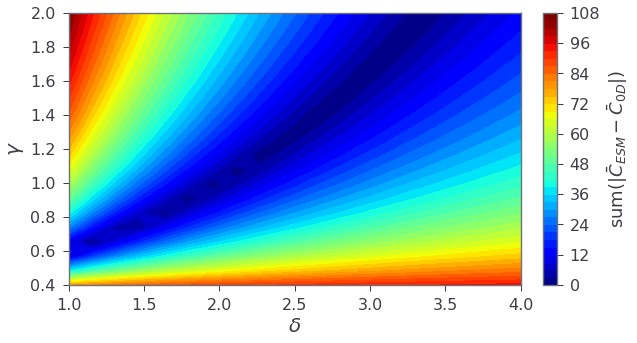

In [130]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
f = ax.contourf(deltas, gamas, diff_85.T, vmin=diff_85.min(), vmax=diff_85.max(), cmap='jet', levels=len(gamas)*2)

fs = 16

cbar1 = fig.colorbar(f, ax=ax, pad=0.04, extend='both')
cbar1.ax.tick_params(labelsize=fs)
cbar1.ax.set_ylabel(r'sum($|\bar{C}_{ESM} - \bar{C}_{0D}|)$', fontsize=fs+2, labelpad=5)

ax.set_xlabel(r'$\delta$', fontsize=fs+4)
ax.set_ylabel(r'$\gamma$', fontsize=fs+4)
ax.tick_params(axis='both', labelsize=fs)

plt.savefig('historical-heatmap.png', bbox_inches='tight', dpi=300)

### 9. Calculate cloud fraction and compare result with MPI-ESM output

In [131]:
# Compute cloud fraction with best set of params
# Best overall values

# Concatenate data
ts_total_85 = xr.concat([data_hist.Ts, data_ssp85.Ts], dim='year')
tc_total_85 = xr.concat([all_Tc_hist[lev], all_Tc_ssp85[lev]], dim='year')
                      
alb_c = 1 - (sigma*(ts_total_85)**4 - emiss*sigma*(tc_total_85)**4)/((1 - alb_surf)*(1 - all_abs[lev])*solar)
cc_final_85 = cf_from_alpha_nonlinear(alb_c, best_gamma_85, best_delta_85)

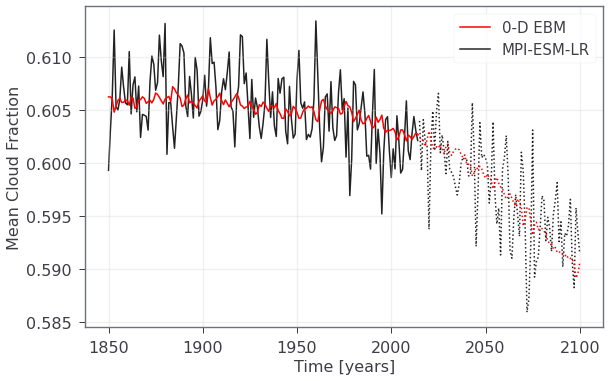

In [132]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(8,5), sharex=True)
fs = 16
plt.subplots_adjust(top=0.95, bottom=0.06, left=0.05, right=0.95, hspace=0.1, wspace=0.3)

#Cloud cover from 0-D EBM
cc_final_85.sel(year=slice(1850,2014)).plot.line(color="red", label='0-D EBM', ax=ax)
cc_final_85.sel(year=slice(2014,2100)).plot.line(color="red", ax=ax, linestyle=':')

#Cloud cover from MPI
data_hist.cc.plot.line(color="k", ax=ax, label='MPI-ESM-LR', zorder=-10)
data_ssp85.cc.plot.line(color="k", linestyle=':', ax=ax, zorder=-10)

ax.set_xlabel('Time [years]', fontsize=fs)
ax.set_ylabel('Mean Cloud Fraction', fontsize=fs)
ax.legend(fontsize=fs-1)
ax.grid(alpha=0.3)
ax.tick_params(axis='both', labelsize=fs)
plt.savefig('cf-comparison.png', bbox_inches='tight', dpi=300)

Plot the albedo vs cloud fraction for best params

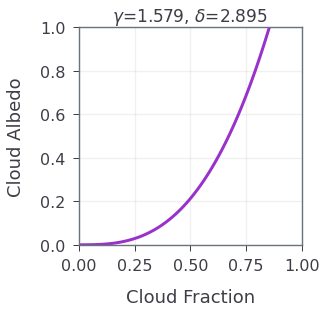

In [138]:
cf = np.linspace(0,1,100)
albc_best_85 = cld_alpha_nonlinear(cf, best_gamma_85, best_delta_85)

fs = 18
plt.figure(figsize=(4,4))

plt.plot(cf, albc_best_85, label=r'$\gamma$={:.3f}, $\delta$={:.3f}'.format(best_gamma_85, best_delta_85), c='darkorchid', linewidth=3)

plt.grid(alpha=0.3)
plt.xlabel(R'Cloud Fraction', fontsize=fs, labelpad=15)
plt.ylabel(r'Cloud Albedo', fontsize=fs, labelpad=15)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(r'$\gamma$={:.3f}, $\delta$={:.3f}'.format(best_gamma_85, best_delta_85), fontsize=fs-1)
plt.tick_params(axis='both', labelsize=fs-2)

plt.savefig('cf-alb.png', bbox_inches='tight', dpi=300)

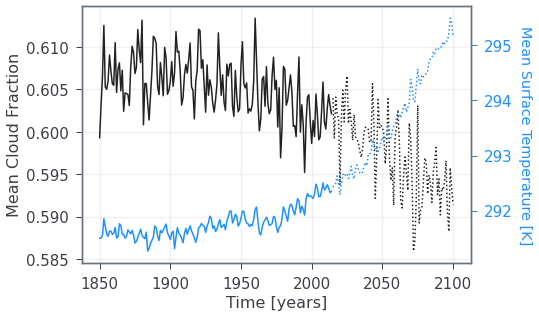

In [139]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(6,4))
fs = 16
plt.subplots_adjust(top=0.95, bottom=0.06, left=0.05, right=0.95, hspace=0.1, wspace=0.3)

ax1 = ax.twinx()

# Surface temperature
data_hist.Ts.plot.line(color="dodgerblue", ax=ax1, label='Historical')
data_ssp85.Ts.plot.line(color="dodgerblue", linestyle=':', ax=ax1, label='SSP5-8.5')

data_hist.cc.plot.line(color="k", ax=ax, label='Historical')
data_ssp85.cc.plot.line(color="k", linestyle=':', ax=ax, label='SSP5-8.5')

ax.set_xlabel('Time [years]', fontsize=fs)
ax.set_ylabel('Mean Cloud Fraction', fontsize=fs)
ax.grid(alpha=0.3)

ax1.tick_params(axis='y', colors='dodgerblue')
ax1.set_ylabel('Mean Surface Temperature [K]', color='dodgerblue', labelpad=20, rotation=270)
ax.tick_params(axis='both', labelsize=fs-1)
ax1.tick_params(axis='both', labelsize=fs-1)

plt.savefig('mpi-outputs.png', bbox_inches='tight', dpi=300)